In [1]:
import numpy as np
import struct
from array import array
import pandas as pd
import os
from os.path  import join
import random as rn
from sklearn.svm import SVC
import graphviz
import pydotplus
from IPython.display import Image
from io import StringIO
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import random
import matplotlib.pyplot as plt
import time

In [2]:
"""
Loading in the dataset into a pandas dataframe object.

For the following segments the code snippets were retreved from: https://www.kaggle.com/code/anetakovacheva/interpreting-a-music-genre-classifier
"""

%matplotlib inline

input_path = 'data/musicgenre_datafolder'
file_path = join(input_path, 'music_genre.csv')

music_data = pd.read_csv(file_path)

In [3]:
"""
Cleaning and Pre-Processing all of the data
"""

"""
There are some duplicated data that needs to be cleaned up
"""
music_data.duplicated().any()
duplicated = music_data.duplicated()
music_data[duplicated]
music_data.iloc[9999:10006]
music_data.drop([10000, 10001, 10002, 10003, 10004], inplace = True)

"""
Removing some columns that don't matter or will complicated the training too much
"""
music_data.reset_index(inplace = True)
music_data = music_data.drop(["artist_name", "index", "instance_id", "track_name", "obtained_date"], axis = 1)

"""
Normalizing the music data such that it removes invalid values for 'tempo' and converts
the column values into a float
"""
music_data = music_data.drop(music_data[music_data["tempo"] == "?"].index)
music_data["tempo"] = music_data["tempo"].astype("float")
music_data["tempo"] = np.around(music_data["tempo"], decimals = 2)

"""
Encoding the columns that are strings with LabelEncoder since this will mess
up the algorithms that require numeric values
"""
key_encoder = LabelEncoder()
mode_encoder = LabelEncoder()
music_data["key"] = key_encoder.fit_transform(music_data["key"])
music_data["mode"] = mode_encoder.fit_transform(music_data["mode"])

"""
Separating out the column features from the music genre label
"""
music_features = music_data.drop("music_genre", axis = 1)
music_labels = music_data["music_genre"]

"""
Scaling the features out into a scale centered around 0 with a standard deviation of 1
"""
scaler = StandardScaler()
music_features_scaled = scaler.fit_transform(music_features)

In [4]:
"""
Splitting the data into Training and Testing Data Sets
"""
train_features, test_features, train_labels, test_labels = train_test_split(
    music_features_scaled, music_labels, test_size = 0.1, stratify = music_labels)


In [5]:
"""
Setting up seed values for reproducability
"""
seed = 1234
np.random.seed(seed)
rn.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [6]:
"""
Getting the size values for the training and testing dataset
"""
size_train_samples = np.shape(train_features)[0]
size_test_samples = np.shape(test_features)[0]

In [7]:
"""
This is to split up the data into sets where the size of the training data across iterations
increases by a certain percentage.
This is to prep the data for the Learning Curve Visualization
"""
learning_percentages_train_list = []
learning_percentages_label_list = []
for i in (np.logspace(-1, 1.0, 20, base=10.0) / 10):
    random_indexes = np.random.choice(size_train_samples, int(i * size_train_samples), replace = False)
    learning_percentages_train_list.append(np.take(train_features, random_indexes, axis=0))
    learning_percentages_label_list.append(np.take(train_labels, random_indexes))

In [8]:
"""
Actually training the SVC to generate the graph for the learning graph visualizer.
This should utilize the percentage of samples lists that use randomly selected samples of the
overall training data. This is so that we can test the accuracy (using cross-validation) across different
training data size samples to see at what point the accuracy score stops being affected by the size of the training
samples. This is also to see at what point the data might start getting overfit.
"""
# Defining hyperparameters here
C = 1.0
kernel = 'rbf'
max_iter = -1

# lists to hold the results of training / validation scores
x_axis_list = []
avg_train_scores_list = []
avg_validation_scores_list = []

# First declaring the Decision Tree Classifer from scikit-learn
clf = SVC(
    C=C,
    kernel=kernel,
    max_iter=max_iter,
    random_state=seed
)

# Main loop for the training based on different training sample sizes
for i in range(0, len(learning_percentages_train_list)):
    scores = cross_validate(
        clf,
        learning_percentages_train_list[i],
        learning_percentages_label_list[i],
        scoring="accuracy",
        return_train_score=True,
        cv=5,
        n_jobs=10,
    )
    
    avg_train_scores = np.average(scores['train_score'])
    avg_validation_scores = np.average(scores['test_score'])
    
    x_axis_list.append(len(learning_percentages_train_list[i]))
    avg_train_scores_list.append(avg_train_scores)
    avg_validation_scores_list.append(avg_validation_scores)
    
    print("=============================================")
    print("Run for " + str(len(learning_percentages_train_list[i])) + " size")
    print("Average Training Score: " + str(avg_train_scores))
    print("Average Validation Score: " + str(avg_validation_scores))
    print("=============================================")

    

Run for 405 size
Average Training Score: 0.737037037037037
Average Validation Score: 0.4864197530864197
Run for 516 size
Average Training Score: 0.7194738945438304
Average Validation Score: 0.47283420463032116
Run for 657 size
Average Training Score: 0.7252695998551512
Average Validation Score: 0.4809738607448531
Run for 838 size
Average Training Score: 0.6873523589207464
Average Validation Score: 0.4677787282577702
Run for 1068 size
Average Training Score: 0.6678362573099416
Average Validation Score: 0.44672019656882095
Run for 1361 size
Average Training Score: 0.6824015556635878
Average Validation Score: 0.5312432665373843
Run for 1734 size
Average Training Score: 0.6691172040084025
Average Validation Score: 0.5103679765454514
Run for 2210 size
Average Training Score: 0.6417420814479639
Average Validation Score: 0.497737556561086
Run for 2816 size
Average Training Score: 0.6450636175645814
Average Validation Score: 0.5319615030926016
Run for 3589 size
Average Training Score: 0.643145

KeyboardInterrupt: 

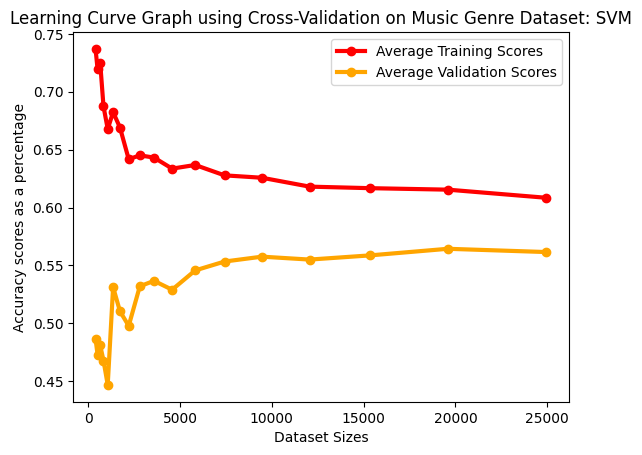

In [9]:
"""
Plotting the results into a learning curve graph
"""

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_scores_list,
    color="red",
    linewidth=3,
    marker='o',
    label = "Average Training Scores"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_scores_list,
    color="orange",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores"
)

# Naming X-Axis
plt.xlabel('Dataset Sizes')
# Naming Y-Axis
plt.ylabel('Accuracy scores as a percentage')
# Naming Title
plt.title("Learning Curve Graph using Cross-Validation on Music Genre Dataset: SVM")

plt.legend()

plt.show()

In [10]:
"""
Actually training the SVC to generate the graph for the learning graph visualizer.
This should utilize the percentage of samples lists that use randomly selected samples of the
overall training data. This is so that we can test the accuracy (using cross-validation) across different
training data size samples to see at what point the accuracy score stops being affected by the size of the training
samples. This is also to see at what point the data might start getting overfit.
"""
# Defining hyperparameters here
C = 1.0
kernel = 'rbf'
max_iter = -1
min_c = 0.1
max_c = 1.0

# lists to hold the results of training / validation scores
x_axis_list = []
avg_train_scores_list = []
avg_validation_scores_list = []


# Main loop for the training based on different training sample sizes
for i in range(1, 11):
    # First declaring the Decision Tree Classifer from scikit-learn
    clf = SVC(
        C=min_c*i,
        kernel=kernel,
        max_iter=max_iter,
        random_state=seed
    )
    scores = cross_validate(
        clf,
        train_features,
        train_labels,
        scoring="accuracy",
        return_train_score=True,
        cv=5,
        n_jobs=10,
    )
    
    avg_train_scores = np.average(scores['train_score'])
    avg_validation_scores = np.average(scores['test_score'])
    
    x_axis_list.append(len(learning_percentages_train_list[i]))
    avg_train_scores_list.append(avg_train_scores)
    avg_validation_scores_list.append(avg_validation_scores)
    
    print("=============================================")
    print("Run for " + str(i) + " size")
    print("Average Training Score: " + str(avg_train_scores))
    print("Average Validation Score: " + str(avg_validation_scores))
    print("=============================================")

    

Run for 1 size
Average Training Score: 0.5641072966407028
Average Validation Score: 0.5540992550380779
Run for 2 size
Average Training Score: 0.5761266451547183
Average Validation Score: 0.5613059505705114
Run for 3 size
Average Training Score: 0.583604810397748
Average Validation Score: 0.5647118497420733
Run for 4 size
Average Training Score: 0.5887321643276969
Average Validation Score: 0.5676735573421128
Run for 5 size
Average Training Score: 0.593106766241825
Average Validation Score: 0.569203784712108


KeyboardInterrupt: 

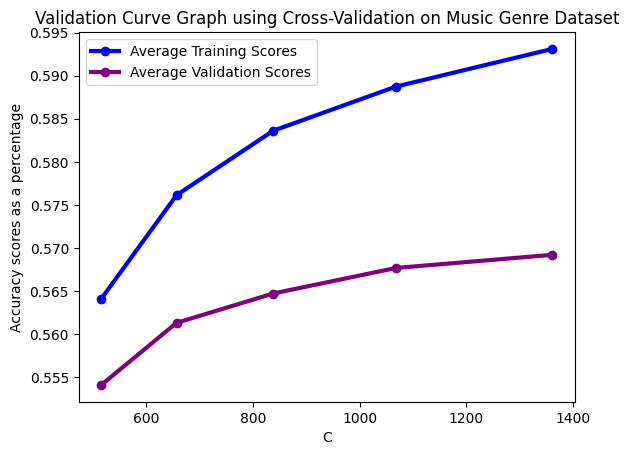

In [11]:
"""
Plotting the results into a validation curve graph
"""

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_scores_list,
    color="blue",
    linewidth=3,
    marker='o',
    label = "Average Training Scores"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_scores_list,
    color="purple",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores"
)

# Naming X-Axis
plt.xlabel('C')
# Naming Y-Axis
plt.ylabel('Accuracy scores as a percentage')
# Naming Title
plt.title("Validation Curve Graph using Cross-Validation on Music Genre Dataset")

plt.legend()

plt.show()

In [12]:
"""
Actually training the SVC to generate the graph for the learning graph visualizer.
This should utilize the percentage of samples lists that use randomly selected samples of the
overall training data. This is so that we can test the accuracy (using cross-validation) across different
training data size samples to see at what point the accuracy score stops being affected by the size of the training
samples. This is also to see at what point the data might start getting overfit.
"""
# Defining hyperparameters here
C = 1.0
kernel = 'linear'
max_iter = -1
min_c = 0.1
max_c = 1.0

# lists to hold the results of training / validation scores
x_axis_list = []
avg_train_scores_list = []
avg_validation_scores_list = []


# First declaring the Decision Tree Classifer from scikit-learn
clf = SVC(
    C=C,
    kernel=kernel,
    max_iter=max_iter,
    random_state=seed
)

# Main loop for the training based on different training sample sizes
for i in range(0, len(learning_percentages_train_list)):
    scores = cross_validate(
        clf,
        learning_percentages_train_list[i],
        learning_percentages_label_list[i],
        scoring="accuracy",
        return_train_score=True,
        cv=5,
        n_jobs=10,
    )
    
    avg_train_scores = np.average(scores['train_score'])
    avg_validation_scores = np.average(scores['test_score'])
    
    x_axis_list.append(len(learning_percentages_train_list[i]))
    avg_train_scores_list.append(avg_train_scores)
    avg_validation_scores_list.append(avg_validation_scores)
    
    print("=============================================")
    print("Run for " + str(len(learning_percentages_train_list[i])) + " size")
    print("Average Training Score: " + str(avg_train_scores))
    print("Average Validation Score: " + str(avg_validation_scores))
    print("=============================================")

    

Run for 405 size
Average Training Score: 0.6586419753086419
Average Validation Score: 0.46419753086419757
Run for 516 size
Average Training Score: 0.6075589459084604
Average Validation Score: 0.4302651232262883
Run for 657 size
Average Training Score: 0.6396552598225602
Average Validation Score: 0.5084779088595882
Run for 838 size
Average Training Score: 0.5954672242364927
Average Validation Score: 0.4988095238095237
Run for 1068 size
Average Training Score: 0.5564126162400538
Average Validation Score: 0.45414856741696286
Run for 1361 size
Average Training Score: 0.598638625560417
Average Validation Score: 0.5231415643180349
Run for 1734 size
Average Training Score: 0.567906808591096
Average Validation Score: 0.5155819493261815
Run for 2210 size
Average Training Score: 0.5548642533936652
Average Validation Score: 0.5122171945701357
Run for 2816 size
Average Training Score: 0.5704014934892415
Average Validation Score: 0.5355246085433909
Run for 3589 size
Average Training Score: 0.561089

KeyboardInterrupt: 

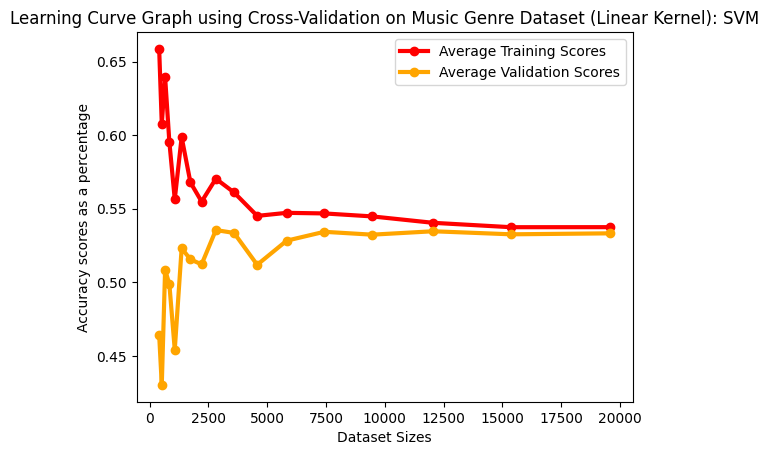

In [13]:
"""
Plotting the results into a learning curve graph
"""

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_scores_list,
    color="red",
    linewidth=3,
    marker='o',
    label = "Average Training Scores"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_scores_list,
    color="orange",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores"
)

# Naming X-Axis
plt.xlabel('Dataset Sizes')
# Naming Y-Axis
plt.ylabel('Accuracy scores as a percentage')
# Naming Title
plt.title("Learning Curve Graph using Cross-Validation on Music Genre Dataset (Linear Kernel): SVM")

plt.legend()

plt.show()

In [14]:
"""
Actually training the SVC to generate the graph for the learning graph visualizer.
This should utilize the percentage of samples lists that use randomly selected samples of the
overall training data. This is so that we can test the accuracy (using cross-validation) across different
training data size samples to see at what point the accuracy score stops being affected by the size of the training
samples. This is also to see at what point the data might start getting overfit.
"""
# Defining hyperparameters here
C = 0.5
kernel = 'linear'
max_iter = -1

# lists to hold the results of training / validation scores
x_axis_list = []
avg_train_scores_list = []
avg_validation_scores_list = []
iteration_wall_clock_list = []

# First declaring the Decision Tree Classifer from scikit-learn
clf = SVC(
    C=C,
    kernel=kernel,
    max_iter=max_iter,
    random_state=seed
)

# Main loop for the training based on different training sample sizes
for i in range(0, len(learning_percentages_train_list)):
    start_time = time.time()
    scores = cross_validate(
        clf,
        learning_percentages_train_list[i],
        learning_percentages_label_list[i],
        scoring="f1_weighted",
        return_train_score=True,
        cv=5,
        n_jobs=10,
    )
    training_time = time.time() - start_time
    
    avg_train_scores = np.average(scores['train_score'])
    avg_validation_scores = np.average(scores['test_score'])
    
    x_axis_list.append(len(learning_percentages_train_list[i]))
    avg_train_scores_list.append(avg_train_scores)
    avg_validation_scores_list.append(avg_validation_scores)
    iteration_wall_clock_list.append(training_time)
    
    print("=============================================")
    print("Run for " + str(len(learning_percentages_train_list[i])) + " size")
    print("Average Training Score: " + str(avg_train_scores))
    print("Average Validation Score: " + str(avg_validation_scores))
    print("Training Time: " + str(training_time))
    print("=============================================")
    

Run for 405 size
Average Training Score: 0.638199656873074
Average Validation Score: 0.47074782980158814
Training Time: 1.7006988525390625
Run for 516 size
Average Training Score: 0.595756930477051
Average Validation Score: 0.4269634030242119
Training Time: 0.7045049667358398
Run for 657 size
Average Training Score: 0.6209797993505356
Average Validation Score: 0.49931409263392146
Training Time: 0.6922497749328613
Run for 838 size
Average Training Score: 0.5811805630029832
Average Validation Score: 0.48164433281057617
Training Time: 0.7157580852508545
Run for 1068 size
Average Training Score: 0.5491508232018321
Average Validation Score: 0.4550297494969516
Training Time: 0.0824286937713623
Run for 1361 size
Average Training Score: 0.5914461949120394
Average Validation Score: 0.5244573427433276
Training Time: 0.0980989933013916
Run for 1734 size
Average Training Score: 0.567571592207825
Average Validation Score: 0.511994246520042
Training Time: 0.14522075653076172
Run for 2210 size
Averag

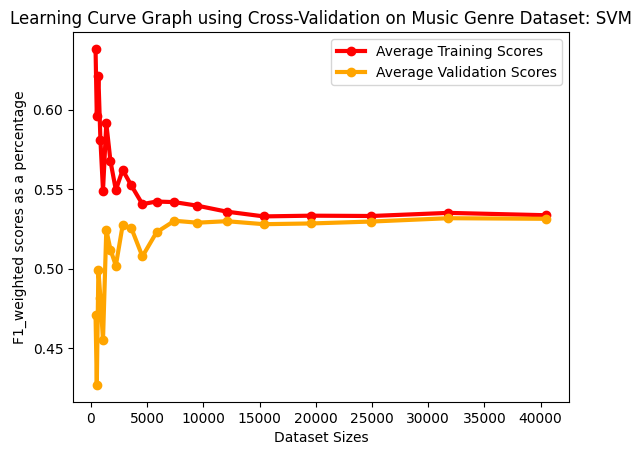

In [15]:
"""
Plotting the results into a learning curve graph
"""

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_scores_list,
    color="red",
    linewidth=3,
    marker='o',
    label = "Average Training Scores"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_scores_list,
    color="orange",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores"
)

# Naming X-Axis
plt.xlabel('Dataset Sizes')
# Naming Y-Axis
plt.ylabel('F1_weighted scores as a percentage')
# Naming Title
plt.title("Learning Curve Graph using Cross-Validation on Music Genre Dataset: SVM")

plt.legend()

plt.show()

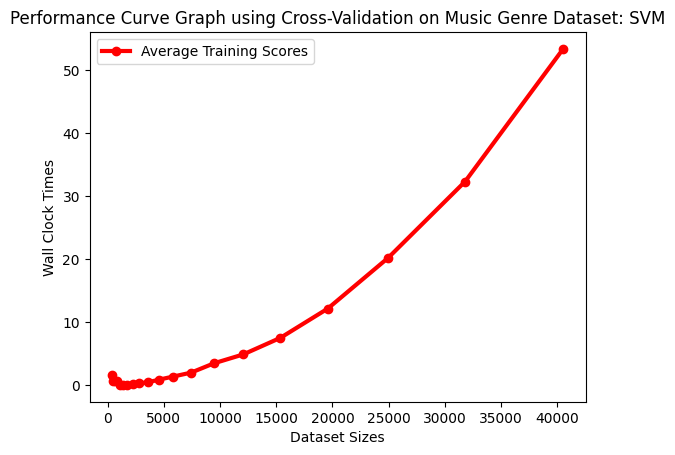

In [16]:
"""
Plotting the results into a learning curve graph
"""

# Plotting the training scores
plt.plot(
    x_axis_list,
    iteration_wall_clock_list,
    color="red",
    linewidth=3,
    marker='o',
    label = "Average Training Scores"
)

# Naming X-Axis
plt.xlabel('Dataset Sizes')
# Naming Y-Axis
plt.ylabel('Wall Clock Times')
# Naming Title
plt.title("Performance Curve Graph using Cross-Validation on Music Genre Dataset: SVM")

plt.legend()

plt.show()

In [17]:
clf.fit(train_features, train_labels)
start_time = time.time()
score = clf.score(test_features, test_labels)
training_time = time.time() - start_time
print(score)
print(training_time)

0.540204353620613
4.521547079086304
